# **Amazon Product Rate Predictor**
### JeongYoon Lee, Dovid Scheinberg, Andrew Chu
---
The goal of this project is to predict the number of stars a buyer would rate a product, given their text review of it.

*Code based on Homework 3*

Import the necessary libraries. *(need to remove the ones we don't need)*

In [ ]:
!pip install datasets
!pip install transformers

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import os
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score, recall_score, f1_score # classification metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from datasets import load_dataset
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/project/submission folder/'

/content/gdrive/.shortcut-targets-by-id/12bQn6IHlaXgvQmuiFGjGLbNC0j_L-m2j/project/submission folder


Load the [amazon_reviews_multi](https://huggingface.co/datasets/amazon_reviews_multi/viewer/en) (English) dataset from [Hugging Face](https://huggingface.co/).

In [ ]:
train_data = load_dataset("amazon_reviews_multi", "en", split='train')
val_data   = load_dataset("amazon_reviews_multi", "en", split='validation')
test_data  = load_dataset("amazon_reviews_multi", "en", split='test')

Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
Reusing dataset amazon_reviews_multi (/root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


In [ ]:
print(train_data)
print(val_data)
print(test_data)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 200000
})
Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5000
})
Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5000
})


# **The Distilbert Model Class**
---
Since we are going to be assigning a text review to a number of stars out of 5 , we will use regression instead of classification.

In [ ]:
class Distilbert():

  def __init__(self, model_name='distilbert-base-uncased', num_labels=5): #I guess our labels are 5 since there are 5 stars 
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels) 

  def get_tokenizer_and_model(self):
    return self.model, self.tokenizer

# **The Dataloader Class**
---
Since we are going to be rating a product out of 5 stars based on a text review, we will use regression.

In [ ]:
import random
class DatasetLoader(Dataset):

  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer

  def tokenize_data(self, num_training):
    print("Processing data..")
    tokens = []
    labels = []

    review_list = self.data['review_body']
    title_list = self.data['review_title']
    label_list = self.data['stars']
    data = list(zip(review_list, label_list, title_list))
    random.shuffle(data)
    num_training = num_training
    data = data[:num_training]
    for review, label, title in tqdm(data, total=len(data)):
      review_encoding = self.tokenizer.encode_plus(title + review, truncation=True, max_length = 512)
      review_encoding = review_encoding['input_ids']
      review_encoding = torch.tensor(review_encoding).cuda()

      tokens.append(review_encoding)
      labels.append(np.float32(label))
      
    tokens = pad_sequence(tokens, batch_first=True)
    labels = torch.tensor(labels)
    dataset = TensorDataset(tokens, labels)
    return dataset

  def get_data_loaders(self, batch_size=32, num_training = 10000, shuffle=True):
    processed_dataset = self.tokenize_data(num_training = num_training)

    data_loader = DataLoader(
        processed_dataset,
        shuffle=shuffle,
        batch_size=batch_size
    )

    return data_loader

# **The Trainer Class**
---

In [ ]:
class Trainer():

  def __init__(self, options):
    self.device = options['device']
    self.train_data = options['train_data']
    self.val_data = options['val_data']
    self.batch_size = options['batch_size']
    self.epochs = options['epochs']
    self.save_path = options['save_path']
    self. num_training = options['num_training']
    transformer = Distilbert()
    self.model, self.tokenizer = transformer.get_tokenizer_and_model()
    self.model.to(self.device)

  def get_performance_metrics(self, preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    accuracy = accuracy_score(labels_flat , pred_flat)
    return accuracy

  def set_training_parameters(self):
    # layer_nums = ["layer.0", "layer.1", "layer.2", "layer.3", "layer.4", "layer.5"] # Training only the last 2 layers, so freeze the first 4
    layer_nums = ["layer.0", "layer.1", "layer.2", "layer.3"] # Training only the last 2 layers, so freeze the first 4

    for name, layer in self.model.named_parameters():
      if any([x in name for x in layer_nums]) or "embeddings" in name:
        layer.requires_grad = False

  def train(self, data_loader, optimizer):
    self.model.train()
    total_loss = 0
    total_acc = 0
    
    loader = tqdm(data_loader)
    for batch_idx, (reviews, labels) in enumerate(loader):
      self.model.zero_grad()
      optimizer.zero_grad()
      labels = labels.to(torch.int64)
      labels = torch.sub(labels, 1)
      labels_onehot = nn.functional.one_hot(labels, num_classes=5).to(torch.float)
      outputs = self.model(reviews.to(self.device), labels=labels_onehot.to(self.device))
      cur_loss = outputs.loss.to(self.device)
      
      cur_loss.backward()
      optimizer.step()

      total_loss += cur_loss
      result = self.get_performance_metrics(outputs['logits'].cpu().detach(), labels.cpu().detach())
      total_acc += result
      loader.set_description("current loss: %.4f" % cur_loss)

    accuracy = total_acc / len(data_loader)
    loss = total_loss/len(data_loader)

    return accuracy, loss

  def eval(self, data_loader):
    self.model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
      for (reviews, labels) in tqdm(data_loader):
        
        labels = labels.to(torch.int64)
        labels = torch.sub(labels, 1)
        labels_onehot = nn.functional.one_hot(labels, num_classes=5).to(torch.float)
        outputs = self.model(reviews.to(self.device), labels=labels_onehot.to(self.device))
        cur_loss = outputs.loss
      
        total_loss += cur_loss
        result = self.get_performance_metrics(outputs['logits'].cpu().detach(), labels.cpu().detach())
        total_acc += result
    
    loss = total_loss/len(data_loader)
    accuracy = total_acc / len(data_loader)

    return accuracy, loss

  def save_transformer(self):
    self.model.save_pretrained(self.save_path)
    self.tokenizer.save_pretrained(self.save_path)

  def execute(self):
    last_best = 0
    train_dataset = DatasetLoader(self.train_data, self.tokenizer)
    train_data_loader = train_dataset.get_data_loaders(self.batch_size, self.num_training)
    val_dataset = DatasetLoader(self.val_data, self.tokenizer)
    val_data_loader = val_dataset.get_data_loaders(self.batch_size, self.num_training)
    optimizer = AdamW(self.model.parameters(), lr = 0.00003, eps = 1e-8)
    self.set_training_parameters()
    plt_epochs = range(1, self.epochs +1)
    plt_train_acc = []
    plt_val_acc = []
    plt_train_loss = []
    plt_val_loss = []

    for epoch_i in range(0, self.epochs):
      train_acc, train_loss = self.train(train_data_loader, optimizer)
      print(f'Epoch {epoch_i + 1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')
      plt_train_acc.append(train_acc)
      plt_train_loss.append(train_loss.detach().cpu().numpy())
      val_acc, val_loss = self.eval(val_data_loader)
      print(f'Epoch {epoch_i + 1}: val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
      plt_val_acc.append(val_acc)
      plt_val_loss.append(val_loss.detach().cpu().numpy())

      if val_acc > last_best:
        print("Saving model..")
        self.save_transformer()
        last_best = val_acc
        print("Model saved.")
    plt.plot(plt_epochs, plt_train_acc,'bo-', label = 'Training Accuracy')
    plt.plot(plt_epochs, plt_val_acc, 'ro-',label = "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    plt.plot(plt_epochs, plt_train_loss, 'bo-', label = 'Training Loss')
    plt.plot(plt_epochs, plt_val_loss, 'ro-',label = "Validation Loss")
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics

# **Training**
---

## Batch Size : 16, Number of dataset : 20K, epochs : 10

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Processing data..


100%|██████████| 20000/20000 [00:04<00:00, 4127.24it/s]


Processing data..


100%|██████████| 5000/5000 [00:01<00:00, 4182.78it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
current loss: 0.2947: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 1: train_loss: 0.3990 train_acc: 0.4504


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 1: val_loss: 0.3250 val_acc: 0.5855
Saving model..
Model saved.


current loss: 0.3455: 100%|██████████| 1250/1250 [08:46<00:00,  2.38it/s]


Epoch 2: train_loss: 0.3128 train_acc: 0.6062


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 2: val_loss: 0.3131 val_acc: 0.6028
Saving model..
Model saved.


current loss: 0.1810: 100%|██████████| 1250/1250 [08:46<00:00,  2.38it/s]


Epoch 3: train_loss: 0.2945 train_acc: 0.6315


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 3: val_loss: 0.3095 val_acc: 0.6022


current loss: 0.2813: 100%|██████████| 1250/1250 [08:46<00:00,  2.38it/s]


Epoch 4: train_loss: 0.2768 train_acc: 0.6642


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 4: val_loss: 0.3124 val_acc: 0.6024


current loss: 0.3631: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 5: train_loss: 0.2587 train_acc: 0.6942


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 5: val_loss: 0.3239 val_acc: 0.6052
Saving model..
Model saved.


current loss: 0.2543: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 6: train_loss: 0.2360 train_acc: 0.7290


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 6: val_loss: 0.3331 val_acc: 0.5992


current loss: 0.1927: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 7: train_loss: 0.2084 train_acc: 0.7680


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 7: val_loss: 0.3635 val_acc: 0.5937


current loss: 0.2995: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 8: train_loss: 0.1822 train_acc: 0.8040


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 8: val_loss: 0.3811 val_acc: 0.5903


current loss: 0.1073: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 9: train_loss: 0.1517 train_acc: 0.8414


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 9: val_loss: 0.4449 val_acc: 0.5771


current loss: 0.0981: 100%|██████████| 1250/1250 [08:45<00:00,  2.38it/s]


Epoch 10: train_loss: 0.1280 train_acc: 0.8693


100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 10: val_loss: 0.4499 val_acc: 0.5789


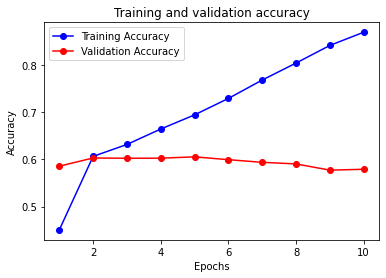

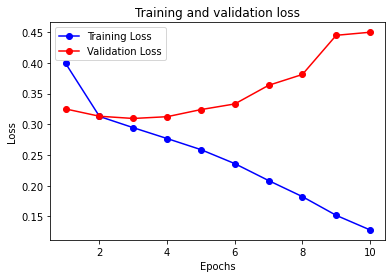

In [ ]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = train_data
options['val_data'] = val_data
options['save_path'] = "Distilbert_classification"
options['epochs'] = 10
options['num_training'] = 20000
trainer = Trainer(options)
trainer.execute()